In [1]:
from pathlib import Path
from argparse import ArgumentParser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot

from nps_utils import compute_nps
from noise_assessments import load_data
from make_noise_patches import make_noise_image_dict, prep_patches

datadir = '/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds'
results_dir = 'results/02-22-2024_13-14_redcnn_augmented_dc_bias_removed'


def get_square_patch(img, center, patch_width=30):
    if img.ndim == 2: img = img[None, :, :]
    return img[:, center[0]-patch_width//2:center[0]+patch_width//2, center[1]-patch_width//2:center[1]+patch_width//2]


def get_patches(img, centers, patch_size=30):
    return {center: get_square_patch(img, center, patch_width=patch_size) for center in centers}


def characterize_noise_texture(datadir, results_dir=None, patch_size=30, max_images=1000, kernel='fbp'):
    fontsize=8
    datadir = Path(datadir)
    results_dir = Path(results_dir)
    results_dict, _ = load_data(datadir, results_dir)

    noise_image_dict = make_noise_image_dict(Path(datadir), max_images=max_images, kernel=kernel)

    diams = [112, 185, 216]

    fig = plt.figure(figsize=(4, 5), dpi=300)
    fig.suptitle(kernel)
    gs = gridspec.GridSpec(3, 2, wspace=0.15, hspace=0.1)

    offset = 1000 if kernel == 'fbp' else 0

    images = np.concatenate([results_dict[d][100][kernel]['image']-offset for d in diams], axis=1)
    coords = [(256, 256), (50, 256), (110, 110)]
    image_patches = [get_patches(results_dict[d][100][kernel]['image']-offset, centers=coords) for d in diams]

    image_stds = [{k: (img.mean(), img.std()) for k, img in p.items()} for p in image_patches]
    ww = 80
    wl = 0
    ax = fig.add_subplot(gs[0, :])
    ax.imshow(images, cmap='gray', vmin=wl-ww//2, vmax=wl+ww//2)
    ax.axis('off')
    ax.set_title(f'(a) {diams} mm Images', fontsize=fontsize)

    for idx, p in enumerate(image_stds):
        for xy, (mean, std) in p.items():
            ax.annotate(f'[{mean:2.0f}, {std:2.0f}] HU', (xy[0] + idx*512, xy[1]), fontsize=5, bbox=dict(boxstyle='square,pad=0.3', fc="lightblue", ec="steelblue"))

    images = np.concatenate([results_dict[d][100][kernel]['noise image'] for d in diams], axis=1)
    image_patches = [get_patches(results_dict[d][100][kernel]['noise image'], centers=coords) for d in diams]

    image_stds = [{k: (img.mean(), img.std()) for k, img in p.items()} for p in image_patches]
    ww2 = np.sqrt(2*ww**2)
    N=1
    ax = fig.add_subplot(gs[1, :])
    ax.imshow(images, cmap='gray', vmin=wl-ww2//2, vmax=wl+ww2//2)
    ax.axis('off')
    ax.set_title(f'(b) {diams} mm Noise Images', fontsize=fontsize)

    for idx, p in enumerate(image_stds):
        for xy, (mean, std) in p.items():
            ax.annotate(f'[{mean:2.0f}, {std:2.0f}] HU', (xy[0] + idx*512, xy[1]), fontsize=5, bbox=dict(boxstyle='square,pad=0.3', fc="lightblue", ec="steelblue"))

    centers = [(256, 256), (50, 256), (110, 110)]
    corner_patches = [get_patches(noise_image_dict[f'diameter{x}mm'], centers=centers, patch_size=patch_size) for x in diams]

    corners= list(corner_patches[0].keys())
    region_patches = np.concatenate([np.concatenate([p[c][0] for p in corner_patches], axis=1) for c in corners])

    ax = fig.add_subplot(gs[2, 0])
    ax.imshow(region_patches, cmap='gray', aspect='equal')
    ax.set_title('(c) patch images', fontsize=fontsize)
    ax.set_xlabel(f'{diams} mm', fontsize=8)
    ax.set_ylabel(f'[upper left, top, center]', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


    ax = fig.add_subplot(gs[2, 1])
    ax.imshow(np.concatenate([np.concatenate([compute_nps(p[c] - p[c].mean()) for p in corner_patches], axis=1) for c in corners]), aspect='equal')
    ax.set_title('(d) patch NPS', fontsize=fontsize)
    ax.set_xlabel(f'{diams} mm', fontsize=8)
    ax.set_ylabel(f'[upper left, top, center]', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    if results_dir is None: return
    fig.savefig(Path(results_dir) /f'{kernel}_noise_texture.png', dpi=600, bbox_inches='tight')


def plot_training_noise_comparison(results_dir=None):
    data_dir = Path('data/')

    train_input = np.load(data_dir/'Denoising_Data/train_input.npy')
    train_target = np.load(data_dir/'Denoising_Data/train_target.npy')

    diams = [112, 151, 185, 292]

    datadir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds')
    noise_patch_dict = prep_patches(datadir)
    training_noise = train_input - train_target
    train_nps = compute_nps(training_noise)

    patches_to_keep_idx = np.squeeze(train_target.mean(axis=(1,2)) > 0)
    train_input = train_input[patches_to_keep_idx]
    train_target = train_target[patches_to_keep_idx]
    training_noise = train_input - train_target


    f, axs = plt.subplots(2, 2, figsize=(4.5, 5), dpi=300, tight_layout=True)
    axs = axs.flatten()

    axs[0].imshow(np.concatenate(
        [np.concatenate(np.squeeze(train_input[3*idx:3+3*idx]), axis=0)
        for idx in range(3)], axis=1), cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(
    '''(a) Example Training
    Inputs''')

    axs[1].imshow(np.concatenate(
        [np.concatenate(np.squeeze(training_noise[3*idx:3+3*idx]), axis=0)
        for idx in range(3)], axis=1), cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(
    '''(b) Example Training
    Noise Textures''')

    axs[2].imshow(train_nps)
    axs[2].axis('off')
    axs[2].set_title(
'''(c) Training Noise
Textures Average NPS''')

    normalize = lambda x: x/x.sum()
    patch_nps = [normalize(compute_nps(noise_patch_dict[f'diameter{x}mm'])) for x in diams]
    axs[3].imshow(np.concatenate(
        [np.concatenate(np.squeeze(patch_nps[2*idx:2+2*idx]), axis=0)
        for idx in range(2)], axis=1))
    idx=0
    for i in range(2):
        for j in range(2):
            axs[3].annotate(f'{diams[idx]} mm', (4+30*i, 4+30*j), color='white')
            idx+=1
    axs[3].set_title(
'''(d) Generated Noise
Textures Average NPS''')
    axs[3].axis('off')
    if results_dir is None: return
    f.savefig(Path(results_dir) /'trainingnoise.png', dpi=600, bbox_inches='tight')


def make_schematic(results_dir):
    'http://magjac.com/graphviz-visual-editor/'
    dot_string = """digraph {
        fontname="Helvetica,Arial,sans-serif"
        node [fontname="Helvetica,Arial,sans-serif"]
        edge [fontname="Helvetica,Arial,sans-serif"]
        layout=dot
        node [shape=box]; {node [label="Training Input"] input};
        node [shape=box]; {node [label="Training Target"] target};
        node [shape=box]; Prediction;
        
        node [shape=ellipse]; Model;
        node [shape=diamond,style=filled,color=lightgrey]; {node [label="Loss Function"] loss};

        input -> Model [len=2.00];
        
        Model -> Prediction [len=2.00];
        Prediction -> loss [len=2.00];
        
        target -> loss [len=2.00];
        loss -> Model [len=2.00];

        fontsize=20;
    }"""

    graphs = pydot.graph_from_dot_data(dot_string)
    graphs[0].write_png(Path(results_dir) / 'standard_training_schematic.png') #<-- requires graphviz (`sudo apt get install graphviz`` or `conda install -c anaconda graphviz``)

    dot_string = r"""digraph {
        fontname="Helvetica,Arial,sans-serif"
        node [fontname="Helvetica,Arial,sans-serif"]
        edge [fontname="Helvetica,Arial,sans-serif"]
        layout=dot
        node [shape=box]; {node [label="Training Input"] input};
        node [shape=box]; {node [label="Training Target"] target};
        node [shape=box]; Prediction;
        node [shape=box]; {node [label="Noise Patches"] patches};
        node [shape=box]; {node [label="Augmented Input"] augmented};

        node [shape=ellipse]; Model;
        node [shape=diamond,style=filled,color=lightgrey]; {node [label="Loss Function"] loss};

        patches -> augmented;
        target ->  augmented [len=2.00];

        input -> Model  [label="1 - λ"];
        augmented -> Model  [label="λ"];
        
        Model -> Prediction [len=2.00];
        Prediction -> loss [len=2.00];
        target -> loss [len=2.00];
        loss -> Model [len=2.00];

        fontsize=20;
    }

    """
    graphs = pydot.graph_from_dot_data(dot_string)
    graphs[0].write_png(Path(results_dir) / 'augmented_training_schematic.png')

def main(args):
    characterize_noise_texture(datadir=args.base_directory, results_dir=args.output_directory, patch_size=args.patch_size)
    plot_training_noise_comparison(args.output_directory)
    make_schematic(args.output_directory)

generating 500 fbp noise images from the following phantom scans: dict_keys(['diameter350mm', 'diameter112mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter131mm', 'diameter292mm', 'diameter151mm'])


100%|██████████| 8/8 [00:00<00:00, 14.16it/s]


generating 500 RED-CNN noise images from the following phantom scans: dict_keys(['diameter350mm', 'diameter112mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter131mm', 'diameter292mm', 'diameter151mm'])


100%|██████████| 8/8 [00:15<00:00,  1.90s/it]


generating 500 RED-CNN augmented noise images from the following phantom scans: dict_keys(['diameter350mm', 'diameter112mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter131mm', 'diameter292mm', 'diameter151mm'])


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


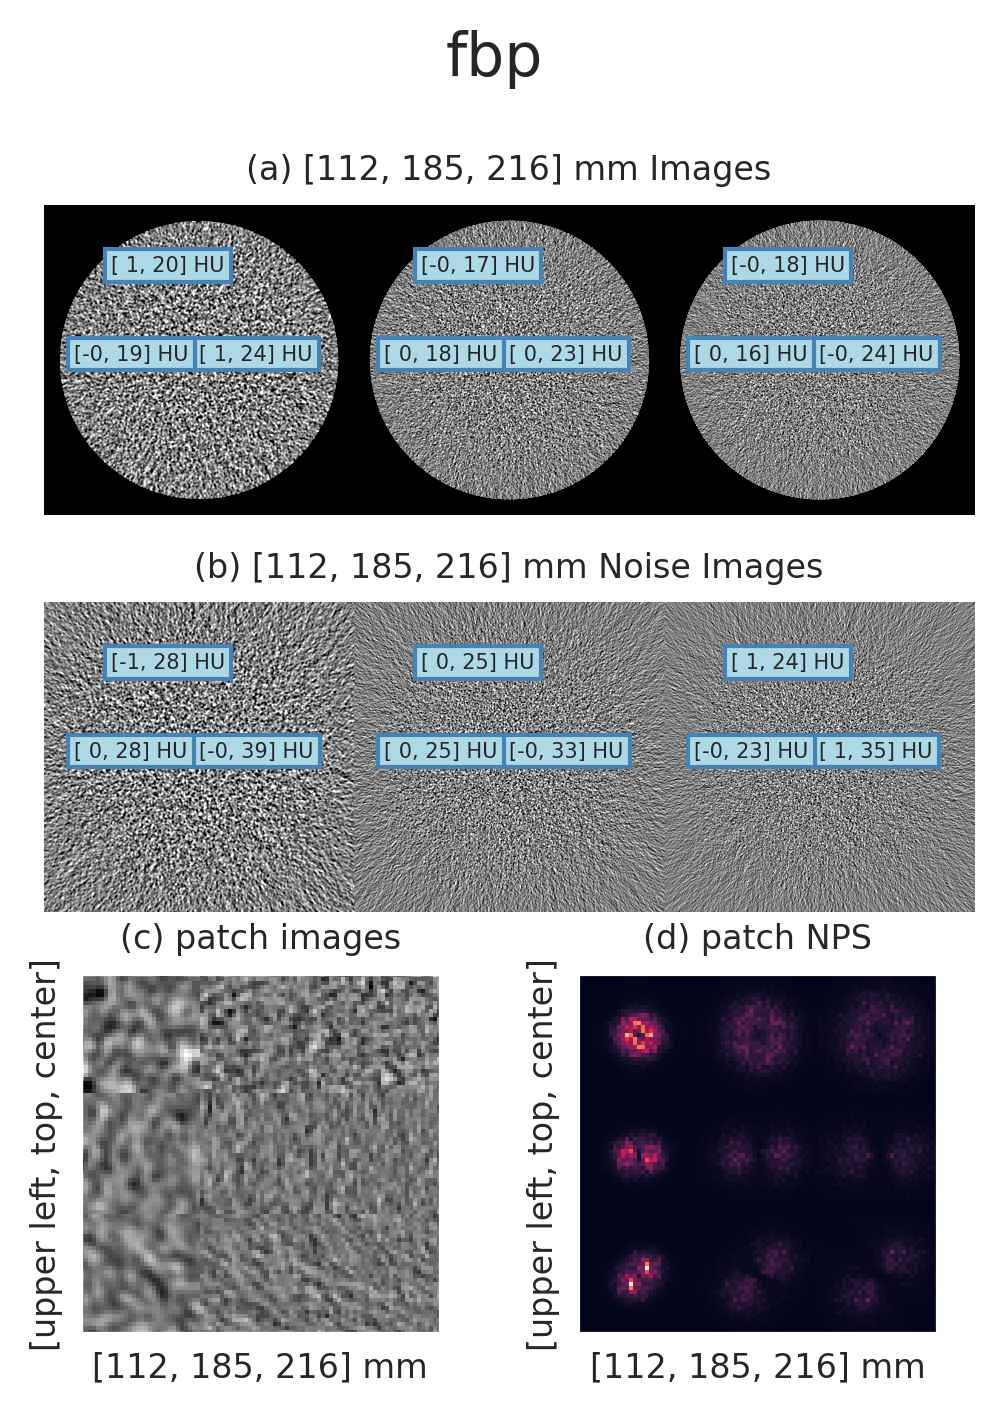

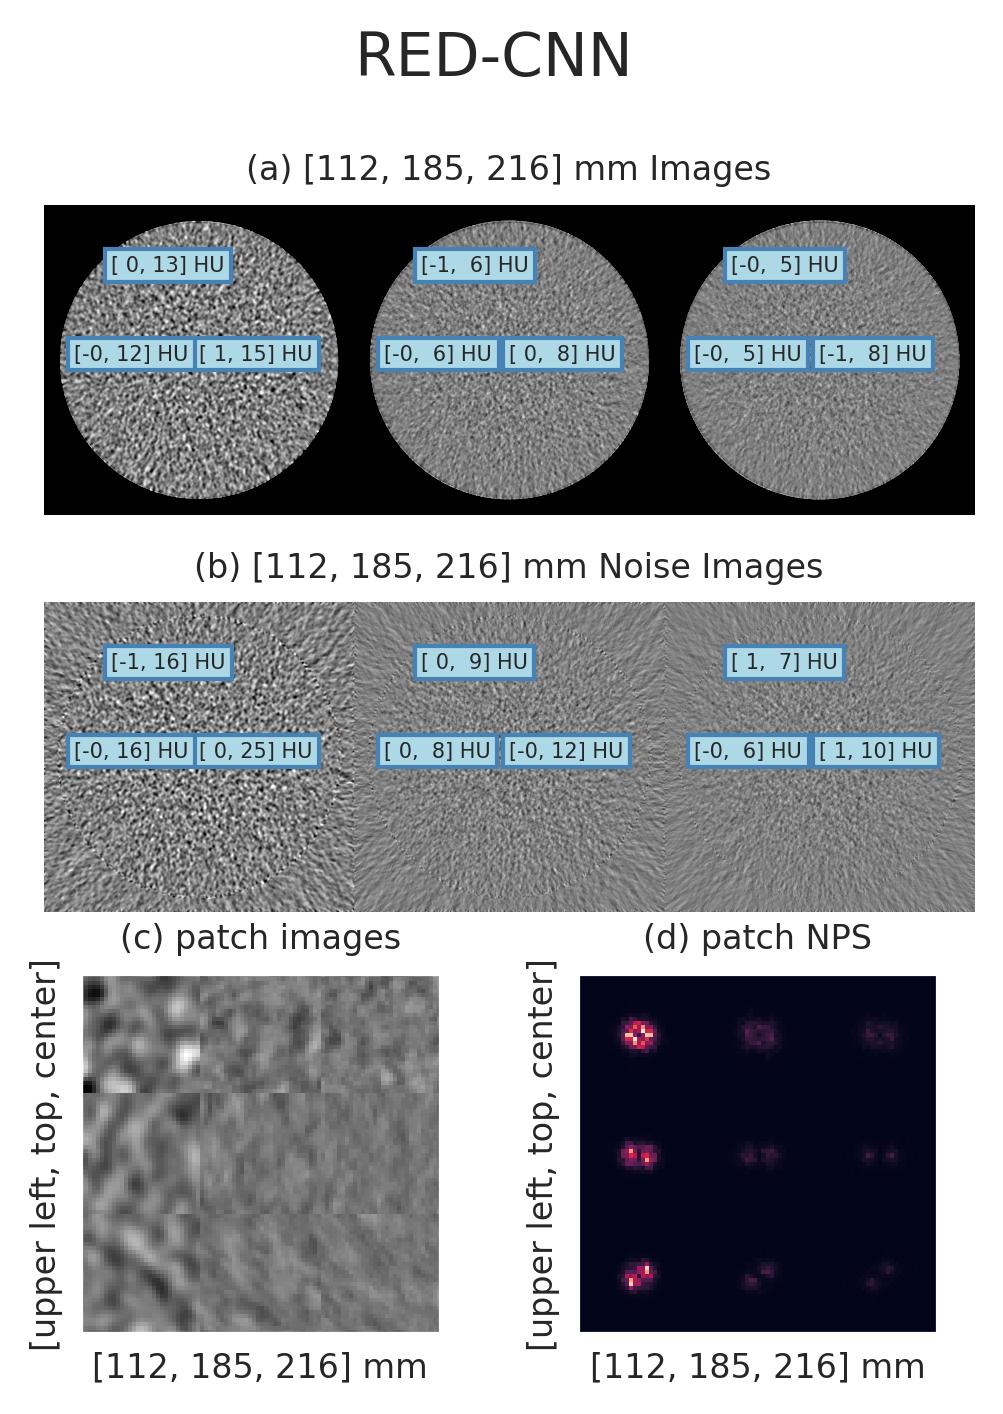

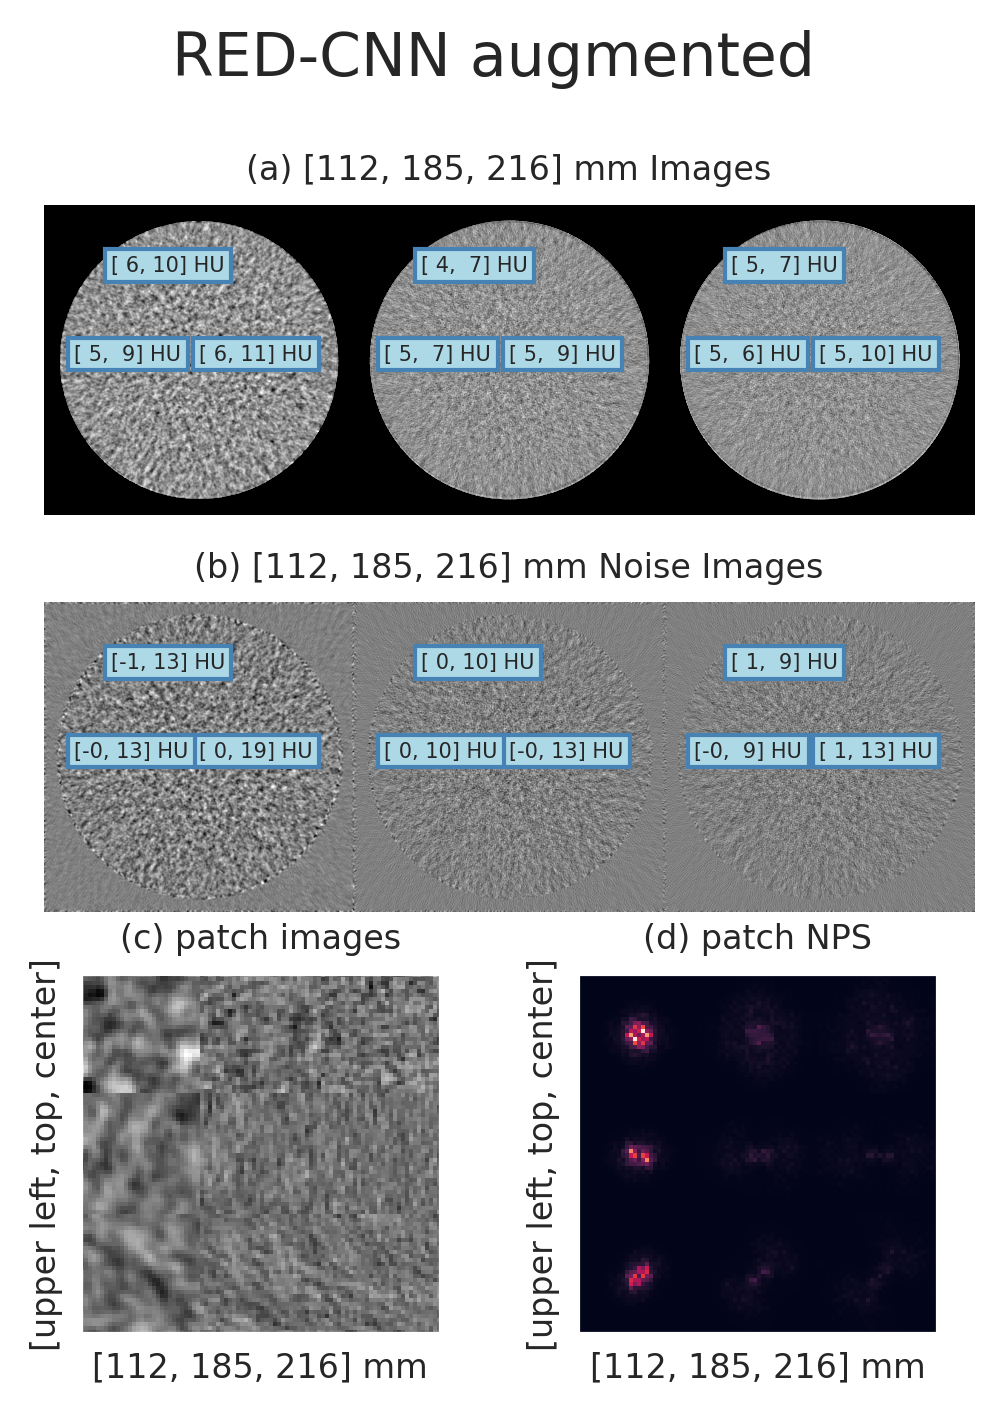

In [2]:
for kernel in ['fbp', 'RED-CNN', 'RED-CNN augmented']:
    characterize_noise_texture(datadir, results_dir, patch_size=30, max_images=500, kernel=kernel)

This is a great example of how we can use this tool to quickly tune our training routines and quantify how texture changes. You can imagine how we could use this to tune the training such that the noise texture is consistent across sizes by using different weighting schemes of the different noise texture sizes and see how that carries through to the final image